In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset
import json
%matplotlib inline

In [2]:
# era_AREA = area_grid_cell(lat, 0.375, 0.375)

In [2]:
nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'
#nc_path  = '//home/hanna/Desktop/examples_master_thesis/'
nc_file  = glob.glob(nc_path + '*.nc')[0]
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan
#d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
#d_theta = lat_array[1:, :] - lat_array[:-1, :]

# Padding the axis -- we removed by taking the difference
#pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values
#d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
#d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

In [3]:
rootgrp

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creator_name: EUMETSAT
    creator_url: http://archive.eumetsat.int
    creator_email: archive@eumetsat.int
    institution: EUMETSAT
    license: CopyRight EUMETSAT 2008
    Conventions: CF-1.0
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    title: EUMETSAT-ARCHIVE-CLOUD-MASK-NetCDF
    summary: NA
    keywords: EUMETSAT, ARCHIVE, NetCDF, CLOUD MASK
    history: EUMETSAT CopyRight 2008
    comment: DRAFT VERSION
    wmo_filename: W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190613053000.nc
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: 0.0
    GRIB_param_Nx: 3712
    GRIB_param_Ny: 3712
    GRIB_orgReferenceTime: 20190613053000
    time_coverage_start: 20190613053000
    time_coverage_end: 20190613053000
    source: /data/products/1338648/MSG4-SEVI-MSGCLMK-0100-0100-20190613053000.000000000Z-20190613054348-1338648.nc.tmp
    dimensions(

In [7]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)


In [8]:
def compute_dDegrees(lat, lon):
    """
    lat, lon shape is (3712, 3712).
    """
    
    assert lat.shape == lon.shape == (3712, 3712), 'Wrong shape of lat and lon expected (3712, 3712), got lat.shape {} and lon.shape {}'.format(lat.shape, lon.shape)
    
    d_phi    = np.nan*np.zeros(np.shape(lat))
    d_theta  = np.nan*np.zeros(np.shape(lat))
    cell_areas = np.nan*np.zeros(np.shape(lat))
    
    for i in range(1, len(lat)-1):
        for j in range(1, len(lat)-1):
            left_half_dist     = (lon[i, j]   - lon[i, j+1])/2
            right_half_dist    = (lon[i, j-1] - lon[i, j])/2                
            #print("left_half_dist {}, right _half_dist {}".format(left_half_dist, right_half_dist))
            dlon               = (np.abs(left_half_dist) + np.abs(right_half_dist))/2
            d_phi[i][j]        = dlon

            upper_half_dist    = (lat[i+1, j] - lat[i, j])/2
            lower_half_dist    = (lat[i, j] - lat[i-1, j])/2
            #print("upper_half_dist {}, lower_half_dist {}".format(upper_half_dist, lower_half_dist))
            dlat               = (np.abs(upper_half_dist) + np.abs(lower_half_dist))/2
            d_theta[i][j]      = dlat
                
            cell_areas[i][j] = area_grid_cell(lat[i, j], dlat, dlon)       
            
    return d_phi, d_theta, cell_areas

In [9]:
d_phi, d_theta, cell_areas = compute_dDegrees(lat_array, lon_array)

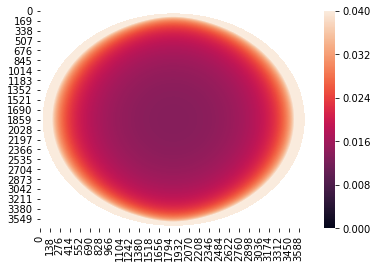

In [10]:
sns.heatmap(d_phi, vmin = 0, vmax = 0.04)

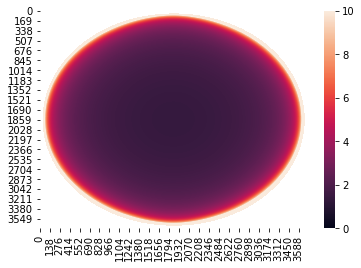

In [11]:
sns.heatmap(cell_areas, vmin = 0, vmax = 10)

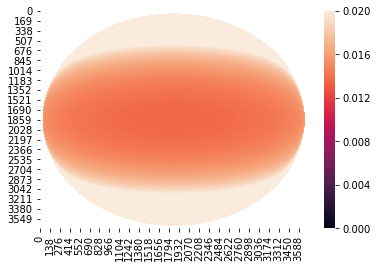

In [12]:
sns.heatmap(d_theta, vmin = 0, vmax = 0.02)

In [13]:
def add(a, b):
    return np.abs(a) + np.abs(b)

def subtract(a, b):
    return np.abs(a) - np.abs(b)

In [14]:
def get_centre_centre_cells():
    pass

In [15]:
def compute_area_one_cell(lat = 60, lon = -15, c_lat = None, 
                          c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    
    era_AREA = area_grid_cell(lat, 0.375, 0.375)
    print("lat = {}, lon ={} era_AREA {}".format(era_AREA, lat, lon))

    # Make this a loop over lat_lons?
    lat_bondaries = np.array([[lon],
                              [lat]])

    BOUND =  np.array([[-0.75/2, 0.75/2],
                       [-0.75/2, 0.75/2]])

    ranges = lat_bondaries + BOUND

    #lon_range = ranges[0, :]
    #lat_range = ranges[1, :]
    #min_lon, max_lon = lon_range
    #min_lat, max_lat = lat_range

    era_up    = ranges[1, 1]
    era_down  = ranges[1, 0]
    era_left  = ranges[0, 0]
    era_right = ranges[0, 1]

    # to ensure correct sign
    cmk_left  = c_lon - np.abs(d_phi)   #- era_right
    cmk_right = c_lon + np.abs(d_phi)   #- era_left

    # TODO : Sjekk d theta og lignende.
    cmk_up    = c_lat + np.abs(d_theta) #- era_down
    cmk_down  = c_lat - np.abs(d_theta) #- era_up

    idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
    idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
    idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
    idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )
    
    idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
    idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
    idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
    idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

    corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                         idx_upper_left_corner, idx_upper_right_corner]) # corner idx
  
    #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
    
    # TODO add new centre corners. And calculate  
    llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
    llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
    llc_lat  = era_down + llc_dlat
    f = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
    #print("area lower left area {}".format(f/era_AREA))
    
    lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
    lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2
    lrc_lat  = era_down + lrc_dlat
    h = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
    #print("area lower right area {}".format(h/era_AREA))
    
    ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
    ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
    ulc_lat = era_up - ulc_dlat
    i = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
    #print("area upper left area {}".format(i/era_AREA))
    
    urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
    urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
    urc_lat  = era_up - ulc_dlat
    j = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
    #print("area upper right area {}".format(j/era_AREA))
    
    #print("SUM corners {}".format((i+j+h+f)/era_AREA))

    if len(corner_idx) == 0:
        raise ValueError('No corners found, something is wrong ... ')
    
    #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
    #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

    # removes corners
    for idx in corner_idx:
        idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
        idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
        idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
        idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]
        
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
    #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
    #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

    #idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
    #idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

    #idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
    #idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]
    
    # subsection left boundary OLD
    low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
    up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
    sub_section_left = np.intersect1d(low_bound, up_bound)

    # subsection right boundary
    low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
    up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
    sub_section_right = np.intersect1d(low_bound, up_bound)

    # Subsection Down Boundary
    one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
    two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
    sub_section_down = np.intersect1d(one, two)

    # subsection up boundary
    one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
    two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
    sub_section_up = np.intersect1d(one, two)
    
    #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
    #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
    #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
    #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
    #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
    #plt.show()
    
    # test that these are empty
    t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
    t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
    assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

    # Calculate Boundaries

    # AREA left boundary
    dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
    dlat_lf = d_theta[idx_left_boundary][sub_section_left]
    lat_lf  = c_lat[idx_left_boundary][sub_section_left]
    #lon_lf  = c_lon[idx_left_boundary][sub_section_left]

    a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

    fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                          dlat_lf,
                                                                                          dlon_lf)/era_AREA).sum()
    # AREA right boundary
    dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
    dlat_rb = d_theta[idx_right_boundary][sub_section_right]
    lat_rb  = c_lat[idx_right_boundary][sub_section_right]
    #lon_rb = c_lon[idx_right_boundary][sub_section_right]

    b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

    fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                             dlat_rb,
                                                                                             dlon_rb)/era_AREA).sum()

    # AREA down boundary
    dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
    lat_down = era_down + dlat_down
    dlon_down = d_phi[idx_down_boundary][sub_section_down]
    #lon_down =  c_lon[idx_down_boundary][sub_section_down]

    c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

    fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                          dlat_down,
                                                                                          dlon_down)/era_AREA).sum()
    # AREA up
    dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
    lat_up = era_up - dlat_up
    #lon_up = c_lon[idx_up_boundary][sub_section_up]
    dlon_up = d_phi[idx_up_boundary][sub_section_up]

    d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

    fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                 dlat_up,
                                                                 dlon_up)/era_AREA).sum()
    # Index centres. Can safly assume centre cells are correct.
    idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                    np.argwhere(cmk_right < era_right))


    idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                    np.argwhere(cmk_down >  era_down))

    idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
    lat_centre_cells = c_lat[idx_centre_cells]
    dlat_centre      = d_theta[idx_centre_cells]
    dlon_centre      = d_phi[idx_centre_cells]
    
    #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
    #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
    #plt.show()
    
    fraction_centre  = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells,
                                                                 dlat_centre,
                                                                 dlon_centre)/era_AREA).sum()
    #print("era_AREA {}".format(era_AREA))
    #print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
    #print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
    #print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
    #print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
    #print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))
    
    Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
                   area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                   area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                   area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                   area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA + (i+j+h+f)/era_AREA
    
    print("SUM weight {}".format(Test_weight[0]))
    return Test_weight[0]


In [16]:
#lats = 
#lons = np.arange(-15, 30, 0.75)

def store_area_index_info(lats = np.arange(30, 56, 0.75), lons = np.arange(-15, 30, 0.75), 
                          c_lat = None, c_lon = None, d_theta = None, d_phi = None, cloud_mask_array = None, 
                          write_fil = False):
    
    assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 
    
    data = {}
    for lat in lats:
        data[str(lat)] = {}
        for lon in lons:
            data[str(lon)] = {}
            era_AREA = area_grid_cell(lat, 0.375, 0.375)
            print("lat = {}, lon = {}".format(lat, lon))
            era_up    = lat + 0.375
            era_down  = lat - 0.375
            era_left  = lon - 0.375
            era_right = lon + 0.375

            # to ensure correct sign
            cmk_left  = c_lon - np.abs(d_phi)   #- era_right
            cmk_right = c_lon + np.abs(d_phi)   #- era_left

            # TODO : Sjekk d theta og lignende.
            cmk_up    = c_lat + np.abs(d_theta) #- era_down
            cmk_down  = c_lat - np.abs(d_theta) #- era_up
            
            data['centre'] = {}
            data['down'] = {}
            data['up'] = {}
            data['right'] = {}
            data['left'] = {}
            data['corner'] = {}
            
            idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
            idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
            idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up),       np.argwhere(cmk_down < era_up) )
            idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down),     np.argwhere(cmk_down < era_down) )

            data['down']['index']  = idx_down_boundary
            data['up']['index']    = idx_up_boundary
            data['left']['index']  = idx_left_boundary
            data['right']['index'] = idx_right_boundary
            
            idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
            idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
            idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
            idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

            corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                                 idx_upper_left_corner, idx_upper_right_corner]) # corner idx
            data['corner']['index'] = corner_idx
            #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))
            
            if len(corner_idx) != 4:
                print("left bound {}".format(cmk_left[corner_idx]))
                print("right bound {}".format(cmk_right[corner_idx]))
                print("up bound {}".format(cmk_up[corner_idx]))
                print("down bound {}".format(cmk_down[corner_idx]))
                
            # TODO add new centre corners. And calculate  
            llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
            llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
            llc_lat  = era_down + llc_dlat
            
            llc_area = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
            #print("area lower left area {}".format(f/era_AREA))

            lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
            lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2
            
            lrc_lat  = era_down + lrc_dlat
            lrc_area = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
            #print("area lower right area {}".format(h/era_AREA))

            ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
            ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
            ulc_lat = era_up - ulc_dlat
            ulc_area = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
            #print("area upper left area {}".format(i/era_AREA))

            urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
            urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
            urc_lat  = era_up - ulc_dlat
            urc_area = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
            #print("area upper right area {}".format(j/era_AREA))
            #print("SUM corners {}".format((i+j+h+f)/era_AREA))

            corner_areas = np.array([lrc_area, llc_area, ulc_area, urc_area])
            data['corner']['area'] = corner_areas
            
            if len(corner_idx) == 0:
                raise ValueError('No corners found, something is wrong ... ')

            #assert len(corner_idx) == 4, "Expected four corners, got {}".format(len(corner_idx))
                           
            #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
            #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

            # removes corners
            for idx in corner_idx:
                idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
                idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
                idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
                idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]

            #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
            #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

            #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
            #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

            #idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
            #idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

            #idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
            #idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]

            # subsection left boundary OLD
            low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up  )
            up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down )
            sub_section_left = np.intersect1d(low_bound, up_bound)
            
            data['left']['index_subset'] = sub_section_left
            
            # subsection right boundary
            low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
            up_bound  = np.argwhere( cmk_up[idx_right_boundary] > era_down)
            sub_section_right = np.intersect1d(low_bound, up_bound)
            data['right']['index_right'] = sub_section_right
            
            # Subsection Down Boundary
            one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
            two = np.argwhere(cmk_right[idx_down_boundary] < era_right)
            sub_section_down = np.intersect1d(one, two)
            data['down']['index_subset'] = sub_section_down

            # subsection up boundary
            one = np.argwhere( cmk_left[idx_up_boundary]  > era_left)
            two = np.argwhere( cmk_right[idx_up_boundary] < era_right)
            sub_section_up = np.intersect1d(one, two)
            data['up']['index_subset'] = sub_section_up
            #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
            #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
            #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
            #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
            #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
            #plt.show()

            # test that these are empty
            t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
            t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
            assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

            # Calculate Boundaries

            # AREA left boundary
            dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
            dlat_lf = d_theta[idx_left_boundary][sub_section_left]
            lat_lf  = c_lat[idx_left_boundary][sub_section_left]
            #lon_lf  = c_lon[idx_left_boundary][sub_section_left]
            left_areas = area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf))
            data['left']['area'] = left_areas
            
            a = np.sum(left_areas)

            fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                                  dlat_lf,
                                                                                                  dlon_lf)/era_AREA).sum()
            # AREA right boundary
            dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
            dlat_rb = d_theta[idx_right_boundary][sub_section_right]
            lat_rb  = c_lat[idx_right_boundary][sub_section_right]
            #lon_rb = c_lon[idx_right_boundary][sub_section_right]
            right_area = area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)) 
            data['right']['area'] = right_area
            b = np.sum(right_area)

            fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                                     dlat_rb,
                                                                                                     dlon_rb)/era_AREA).sum()

            # AREA down boundary
            dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
            lat_down = era_down + dlat_down
            dlon_down = d_phi[idx_down_boundary][sub_section_down]
            #lon_down =  c_lon[idx_down_boundary][sub_section_down]
            down_area = area_grid_cell(lat_down, dlat_down, dlon_down)
            c = np.sum(down_area)
            data['down']['area'] = down_area
            fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                                  dlat_down,
                                                                                                  dlon_down)/era_AREA).sum()
            # AREA up
            dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
            lat_up = era_up - dlat_up
            #lon_up = c_lon[idx_up_boundary][sub_section_up]
            dlon_up = d_phi[idx_up_boundary][sub_section_up]
            up_area = area_grid_cell(lat_up, dlat_up, np.abs(dlon_up))
            data['up']['area'] = up_area
            d = np.sum(up_area)

            fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                                             dlat_up,
                                                                                             dlon_up)/era_AREA).sum()
            # Index centres. Can safly assume centre cells are correct.
            idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                            np.argwhere(cmk_right < era_right))


            idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                            np.argwhere(cmk_down >  era_down))

            idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
            data['centre']['index'] = idx_centre_cells
            
            lat_centre_cells = c_lat[idx_centre_cells]
            dlat_centre      = d_theta[idx_centre_cells]
            dlon_centre      = d_phi[idx_centre_cells]
            centre_area      = area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre)
            
            data['centre']['area'] = centre_area
            #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
            #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
            #plt.show()

            fraction_centre  = (cloud_mask_array[idx_centre_cells]*centre_area/era_AREA).sum()
            #print("era_AREA {}".format(era_AREA))
            #print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
            #print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
            #print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
            #print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
            #print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))

            #Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
            #               area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
            #               area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
            #               area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
            #               area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() ) /era_AREA + (i+j+h+f)/era_AREA

    #print("SUM weight {}".format(Test_weight[0]))
    return data


In [17]:
data_dict = store_area_index_info(lats = np.arange(30, 56, 0.75), lons = np.arange(-15, 30, 0.75), 
                                  c_lat = lat_array.reshape(-1), 
                                  c_lon = lon_array.reshape(-1), d_theta = d_theta.reshape(-1), 
                                  d_phi = d_phi.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1),
                                  write_fil = False)

lat = 30.0, lon = -15.0


/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value enc

lat = 30.0, lon = -14.25
lat = 30.0, lon = -13.5
lat = 30.0, lon = -12.75
lat = 30.0, lon = -12.0
lat = 30.0, lon = -11.25
lat = 30.0, lon = -10.5
lat = 30.0, lon = -9.75
lat = 30.0, lon = -9.0
lat = 30.0, lon = -8.25
lat = 30.0, lon = -7.5
lat = 30.0, lon = -6.75
lat = 30.0, lon = -6.0
lat = 30.0, lon = -5.25
lat = 30.0, lon = -4.5
lat = 30.0, lon = -3.75
lat = 30.0, lon = -3.0
lat = 30.0, lon = -2.25
lat = 30.0, lon = -1.5
lat = 30.0, lon = -0.75
lat = 30.0, lon = 0.0
lat = 30.0, lon = 0.75
lat = 30.0, lon = 1.5
lat = 30.0, lon = 2.25
lat = 30.0, lon = 3.0
lat = 30.0, lon = 3.75
lat = 30.0, lon = 4.5
lat = 30.0, lon = 5.25
lat = 30.0, lon = 6.0
lat = 30.0, lon = 6.75
lat = 30.0, lon = 7.5
lat = 30.0, lon = 8.25
lat = 30.0, lon = 9.0
lat = 30.0, lon = 9.75
lat = 30.0, lon = 10.5
lat = 30.0, lon = 11.25
lat = 30.0, lon = 12.0
lat = 30.0, lon = 12.75
lat = 30.0, lon = 13.5
lat = 30.0, lon = 14.25
lat = 30.0, lon = 15.0
lat = 30.0, lon = 15.75
lat = 30.0, lon = 16.5
lat = 30.0, lon = 17.

lat = 33.0, lon = 27.0
lat = 33.0, lon = 27.75
lat = 33.0, lon = 28.5
lat = 33.0, lon = 29.25
lat = 33.75, lon = -15.0
lat = 33.75, lon = -14.25
lat = 33.75, lon = -13.5
left bound [-13.15857744 -13.13026285 -13.88841486 -13.89273667 -13.15542483]
right bound [-13.12391806 -13.09559393 -13.85357237 -13.85753608 -13.12041211]
up bound [33.37546253 33.41067505 33.39504719 34.15540123 34.13520432]
down bound [33.33936596 33.3745575  33.35891247 34.11876869 34.09861374]
lat = 33.75, lon = -12.75
left bound [-12.40395403 -13.15857744 -13.13026285 -13.15542483 -12.39331532]
right bound [-12.36945677 -13.12391806 -13.09559393 -13.12041211 -12.35846806]
up bound [33.39222813 33.37546253 33.41067505 34.13520432 34.15187073]
down bound [33.35614681 33.33936596 33.3745575  34.09861374 34.11529541]
lat = 33.75, lon = -12.0
lat = 33.75, lon = -11.25
lat = 33.75, lon = -10.5
lat = 33.75, lon = -9.75
lat = 33.75, lon = -9.0
lat = 33.75, lon = -8.25
lat = 33.75, lon = -7.5
lat = 33.75, lon = -6.75
lat

lat = 36.75, lon = 21.75
lat = 36.75, lon = 22.5
lat = 36.75, lon = 23.25
lat = 36.75, lon = 24.0
lat = 36.75, lon = 24.75
lat = 36.75, lon = 25.5
lat = 36.75, lon = 26.25
lat = 36.75, lon = 27.0
lat = 36.75, lon = 27.75
lat = 36.75, lon = 28.5
lat = 36.75, lon = 29.25
lat = 37.5, lon = -15.0
lat = 37.5, lon = -14.25
lat = 37.5, lon = -13.5
lat = 37.5, lon = -12.75
lat = 37.5, lon = -12.0
lat = 37.5, lon = -11.25
lat = 37.5, lon = -10.5
lat = 37.5, lon = -9.75
lat = 37.5, lon = -9.0
lat = 37.5, lon = -8.25
lat = 37.5, lon = -7.5
lat = 37.5, lon = -6.75
lat = 37.5, lon = -6.0
lat = 37.5, lon = -5.25
lat = 37.5, lon = -4.5
lat = 37.5, lon = -3.75
lat = 37.5, lon = -3.0
lat = 37.5, lon = -2.25
lat = 37.5, lon = -1.5
lat = 37.5, lon = -0.75
lat = 37.5, lon = 0.0
lat = 37.5, lon = 0.75
lat = 37.5, lon = 1.5
lat = 37.5, lon = 2.25
lat = 37.5, lon = 3.0
lat = 37.5, lon = 3.75
lat = 37.5, lon = 4.5
lat = 37.5, lon = 5.25
lat = 37.5, lon = 6.0
lat = 37.5, lon = 6.75
lat = 37.5, lon = 7.5
lat = 

lat = 39.75, lon = 26.25
lat = 39.75, lon = 27.0
lat = 39.75, lon = 27.75
lat = 39.75, lon = 28.5
lat = 39.75, lon = 29.25
lat = 40.5, lon = -15.0
lat = 40.5, lon = -14.25
lat = 40.5, lon = -13.5
lat = 40.5, lon = -12.75
left bound [-12.40027785 -13.12694216 -13.14157629 -12.40561986 -12.37599325]
right bound [-12.36213517 -13.08860159 -13.10274363 -12.36699176 -12.3373456 ]
up bound [40.13048935 40.15226936 40.8983078  40.87586498 40.91675854]
down bound [40.08919907 40.11092949 40.85625458 40.83386707 40.87472248]
lat = 40.5, lon = -12.0
left bound [-11.64739084 -12.40027785 -12.40561986 -12.37599325 -11.64342284]
right bound [-11.60941458 -12.36213517 -12.36699176 -12.3373456  -11.60496545]
up bound [40.15025425 40.13048935 40.87586498 40.91675854 40.89570332]
down bound [40.10897732 40.08919907 40.83386707 40.87472248 40.85371685]
lat = 40.5, lon = -11.25
lat = 40.5, lon = -10.5
lat = 40.5, lon = -9.75
lat = 40.5, lon = -9.0
lat = 40.5, lon = -8.25
lat = 40.5, lon = -7.5
lat = 40.5

lat = 42.0, lon = 20.25
left bound [20.61733198 19.8632803  19.837255   19.8579011  20.6054635 ]
right bound [20.65942049 19.90499973 19.87899256 19.90020514 20.64810705]
up bound [41.66289711 41.62680817 41.66806602 42.39770412 42.39081287]
down bound [41.619627   41.58363342 41.62484932 42.35371494 42.3467741 ]
lat = 42.0, lon = 21.0
lat = 42.0, lon = 21.75
lat = 42.0, lon = 22.5
lat = 42.0, lon = 23.25
left bound [23.58502769 22.86637545 22.83932924 23.61103106 23.58687973]
right bound [23.62861824 22.90957594 22.88309431 23.65522337 23.63109207]
up bound [41.64664555 41.65023613 42.37689114 42.37610149 42.41796303]
down bound [41.60314846 41.60679817 42.3326807  42.3318224  42.37364006]
lat = 42.0, lon = 24.0
left bound [24.35377312 23.58502769 23.61103106 23.58687973 24.36605644]
right bound [24.39780235 23.62861824 23.65522337 23.63109207 24.41072273]
up bound [41.64692783 41.64664555 42.37610149 42.41796303 42.4187851 ]
down bound [41.60336208 41.60314846 42.3318224  42.37364006

lat = 44.25, lon = 22.5
left bound [22.83344364 22.11613798 22.09174252 22.10809803 22.86006308]
right bound [22.87850475 22.16077089 22.13639927 22.1534071  22.90579081]
up bound [43.91619968 43.87669086 43.92017651 44.64490795 44.64131832]
down bound [43.87023067 43.8308363  43.87427235 44.59811878 44.59446049]
lat = 44.25, lon = 23.25
lat = 44.25, lon = 24.0
lat = 44.25, lon = 24.75
lat = 44.25, lon = 25.5
lat = 44.25, lon = 26.25
lat = 44.25, lon = 27.0
left bound [27.35537577 27.33366489 26.59657288 26.58093548 27.32793713]
right bound [27.40331793 27.3816328  26.64400864 26.62905216 27.37660313]
up bound [43.87675571 43.92008877 43.91736603 44.63920021 44.6424408 ]
down bound [43.83035183 43.87363529 43.8710022  44.59193993 44.59508514]
lat = 44.25, lon = 27.75
left bound [28.09992075 27.35537577 27.33366489 27.32793713 28.08299303]
right bound [28.14842367 27.40331793 27.3816328  27.37660313 28.13223982]
up bound [43.88109016 43.87675571 43.92008877 44.6424408  44.64735508]
down

lat = 46.5, lon = 15.75
lat = 46.5, lon = 16.5
lat = 46.5, lon = 17.25
lat = 46.5, lon = 18.0
lat = 46.5, lon = 18.75
lat = 46.5, lon = 19.5
lat = 46.5, lon = 20.25
lat = 46.5, lon = 21.0
lat = 46.5, lon = 21.75
lat = 46.5, lon = 22.5
lat = 46.5, lon = 23.25
lat = 46.5, lon = 24.0
left bound [24.37394571 24.35185528 23.58647585 23.61195374 24.36313057]
right bound [24.42203665 24.39997959 23.63406324 23.66034698 24.4120121 ]
up bound [46.1261797  46.17224979 46.12561703 46.89375401 46.89181042]
down bound [46.0772047  46.12321377 46.07672977 46.84377956 46.84174824]
lat = 46.5, lon = 24.75
left bound [25.12061024 25.09899902 24.37394571 24.35185528 24.36313057 25.12131739]
right bound [25.16919994 25.14762115 24.42203665 24.39997959 24.4120121  25.17071676]
up bound [46.12552547 46.17157269 46.1261797  46.17224979 46.89181042 46.89158154]
down bound [46.07646275 46.12244892 46.0772047  46.12321377 46.84174824 46.8414278 ]
lat = 46.5, lon = 25.5
left bound [25.8744812  25.85334826 25.12

left bound [28.86720085 28.10914469 28.10287428 28.08519077 28.87304163]
right bound [28.92041206 28.16169119 28.15632677 28.13868999 28.92718649]
up bound [47.63755608 47.63189411 48.37839222 48.42746544 48.38467407]
down bound [47.58574867 47.58021069 48.32551861 48.37451363 48.33166504]
lat = 48.0, lon = 29.25
lat = 48.75, lon = -15.0
lat = 48.75, lon = -14.25
lat = 48.75, lon = -13.5
lat = 48.75, lon = -12.75
lat = 48.75, lon = -12.0
lat = 48.75, lon = -11.25
lat = 48.75, lon = -10.5
lat = 48.75, lon = -9.75
lat = 48.75, lon = -9.0
lat = 48.75, lon = -8.25
lat = 48.75, lon = -7.5
lat = 48.75, lon = -6.75
lat = 48.75, lon = -6.0
lat = 48.75, lon = -5.25
lat = 48.75, lon = -4.5
lat = 48.75, lon = -3.75
lat = 48.75, lon = -3.0
lat = 48.75, lon = -2.25
lat = 48.75, lon = -1.5
lat = 48.75, lon = -0.75
lat = 48.75, lon = 0.0
lat = 48.75, lon = 0.75
lat = 48.75, lon = 1.5
lat = 48.75, lon = 2.25
lat = 48.75, lon = 3.0
lat = 48.75, lon = 3.75
lat = 48.75, lon = 4.5
lat = 48.75, lon = 5.25


lat = 50.25, lon = 24.0
lat = 50.25, lon = 24.75
lat = 50.25, lon = 25.5
lat = 50.25, lon = 26.25
lat = 50.25, lon = 27.0
lat = 50.25, lon = 27.75
lat = 50.25, lon = 28.5
lat = 50.25, lon = 29.25
left bound [29.59067822 29.57604837 28.82678223 28.84627914 29.60877037]
right bound [29.64750767 29.632936   28.88293457 28.90351486 29.66677666]
up bound [49.87793446 49.92934036 49.92416286 50.67063332 50.6764698 ]
down bound [49.82219982 49.87351608 49.86848545 50.61354637 50.61922264]
lat = 51.0, lon = -15.0
lat = 51.0, lon = -14.25
lat = 51.0, lon = -13.5
lat = 51.0, lon = -12.75
lat = 51.0, lon = -12.0
lat = 51.0, lon = -11.25
lat = 51.0, lon = -10.5
lat = 51.0, lon = -9.75
lat = 51.0, lon = -9.0
lat = 51.0, lon = -8.25
lat = 51.0, lon = -7.5
lat = 51.0, lon = -6.75
lat = 51.0, lon = -6.0
lat = 51.0, lon = -5.25
lat = 51.0, lon = -4.5
lat = 51.0, lon = -3.75
lat = 51.0, lon = -3.0
lat = 51.0, lon = -2.25
lat = 51.0, lon = -1.5
lat = 51.0, lon = -0.75
lat = 51.0, lon = 0.0
lat = 51.0, lo

lat = 52.5, lon = 9.0
lat = 52.5, lon = 9.75
lat = 52.5, lon = 10.5
lat = 52.5, lon = 11.25
left bound [11.60438061 10.82841015 10.84201026 11.61532974 11.58350372]
right bound [11.65302372 10.87678432 10.89132142 11.66484261 11.63307953]
up bound [52.17876434 52.15259647 52.90780449 52.87547493 52.93314838]
down bound [52.12090302 52.09484005 52.84848976 52.81617546 52.87372875]
lat = 52.5, lon = 12.0
left bound [12.36679435 11.60438061 11.61532974 11.58350372 12.35999513]
right bound [12.41565156 11.65302372 11.66484261 11.63307953 12.40979362]
up bound [52.14887905 52.17876434 52.87547493 52.93314838 52.90260887]
down bound [52.09101963 52.12090302 52.81617546 52.87372875 52.84319496]
lat = 52.5, lon = 12.75
lat = 52.5, lon = 13.5
lat = 52.5, lon = 14.25
lat = 52.5, lon = 15.0
lat = 52.5, lon = 15.75
lat = 52.5, lon = 16.5
lat = 52.5, lon = 17.25
lat = 52.5, lon = 18.0
lat = 52.5, lon = 18.75
lat = 52.5, lon = 19.5
lat = 52.5, lon = 20.25
lat = 52.5, lon = 21.0
lat = 52.5, lon = 21.

In [18]:
data_dict

{'-0.75': {},
 '-1.5': {},
 '-10.5': {},
 '-11.25': {},
 '-12.0': {},
 '-12.75': {},
 '-13.5': {},
 '-14.25': {},
 '-15.0': {},
 '-2.25': {},
 '-3.0': {},
 '-3.75': {},
 '-4.5': {},
 '-5.25': {},
 '-6.0': {},
 '-6.75': {},
 '-7.5': {},
 '-8.25': {},
 '-9.0': {},
 '-9.75': {},
 '0.0': {},
 '0.75': {},
 '1.5': {},
 '10.5': {},
 '11.25': {},
 '12.0': {},
 '12.75': {},
 '13.5': {},
 '14.25': {},
 '15.0': {},
 '15.75': {},
 '16.5': {},
 '17.25': {},
 '18.0': {},
 '18.75': {},
 '19.5': {},
 '2.25': {},
 '20.25': {},
 '21.0': {},
 '21.75': {},
 '22.5': {},
 '23.25': {},
 '24.0': {},
 '24.75': {},
 '25.5': {},
 '26.25': {},
 '27.0': {},
 '27.75': {},
 '28.5': {},
 '29.25': {},
 '3.0': {},
 '3.75': {},
 '30.0': {},
 '30.75': {},
 '31.5': {},
 '32.25': {},
 '33.0': {},
 '33.75': {},
 '34.5': {},
 '35.25': {},
 '36.0': {},
 '36.75': {},
 '37.5': {},
 '38.25': {},
 '39.0': {},
 '39.75': {},
 '4.5': {},
 '40.5': {},
 '41.25': {},
 '42.0': {},
 '42.75': {},
 '43.5': {},
 '44.25': {},
 '45.0': {},
 '

In [ ]:
with open(nc_path + 'index_area.json', 'w') as f:
    json.dump(data_dict, f)

In [ ]:
areas = []
lats = np.arange(30, 56, 0.75)
lons = np.arange(-15, 30, 0.75)

for la in lats:
    for lo in lons:
        area = compute_area_one_cell(lat = la, lon = lo, c_lat = lat_array.reshape(-1), 
                              c_lon = lon_array.reshape(-1), d_theta = d_theta_new2.reshape(-1), 
                              d_phi = d_phi_new2.reshape(-1), cloud_mask_array = cloud_mask.reshape(-1)  )
        areas.append(area)

In [15]:
#areas

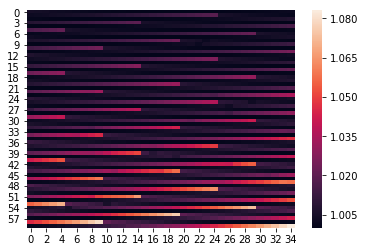

In [16]:
# reshape and make heatmap of aeras.
import seaborn as sns

ax = sns.heatmap((np.array(areas)).reshape(len(lons), len(lats)))
#ax.set_xticklabels(lons)
#ax.set_yticklabels(lats)

In [25]:
lons 

array([-15.  , -14.25, -13.5 , -12.75, -12.  , -11.25, -10.5 ,  -9.75,
        -9.  ,  -8.25,  -7.5 ,  -6.75,  -6.  ,  -5.25,  -4.5 ,  -3.75,
        -3.  ,  -2.25,  -1.5 ,  -0.75,   0.  ,   0.75,   1.5 ,   2.25,
         3.  ,   3.75,   4.5 ,   5.25,   6.  ,   6.75,   7.5 ,   8.25,
         9.  ,   9.75,  10.5 ,  11.25,  12.  ,  12.75,  13.5 ,  14.25,
        15.  ,  15.75,  16.5 ,  17.25,  18.  ,  18.75,  19.5 ,  20.25,
        21.  ,  21.75,  22.5 ,  23.25,  24.  ,  24.75,  25.5 ,  26.25,
        27.  ,  27.75,  28.5 ,  29.25])

In [31]:
xticks

array([-15.  , -12.25,  -9.5 ,  -6.75,  -4.  ,  -1.25,   1.5 ,   4.25,
         7.  ,   9.75,  12.5 ,  15.25,  18.  ,  20.75,  23.5 ,  26.25,
        29.  ])

In [32]:
np.arange()

TypeError: Required argument 'start' (pos 1) not found

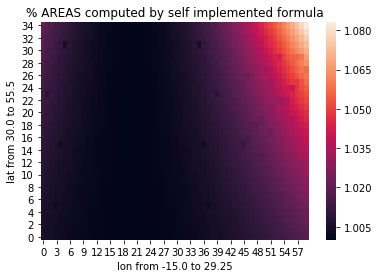

In [36]:
ax = sns.heatmap((np.array(areas)).reshape(len(lats), len(lons)))
ax.invert_yaxis()
ax.set_xlabel("lon from {} to {}".format(min(lons), max(lons)))
ax.set_ylabel("lat from {} to {}".format(min(lats), max(lats)))
#ax.yticklabels(visible = False);
#ax.set_xticklabels(lons);
ax.set_title("% AREAS computed by self implemented formula")
#plt.savefig('test_areas.png')